# [NTDS'19] tutorial 5: machine learning with scikit-learn
[ntds'19]: https://github.com/mdeff/ntds_2019

[Nicolas Aspert](https://people.epfl.ch/nicolas.aspert), [EPFL LTS2](https://lts2.epfl.ch).

* Dataset: [digits](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)
* Tools: [scikit-learn](https://scikit-learn.org/stable/), [numpy](http://www.numpy.org), [scipy](https://www.scipy.org), [matplotlib](https://matplotlib.org)

*scikit-learn* is a machine learning python library. Most commonly used algorithms for classification, clustering and regression are implemented as part of the library, e.g.
* [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression)
* [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering)
* [Support vector machines](https://en.wikipedia.org/wiki/Support-vector_machine)
* ...

The aim of this tutorial is to show basic usage of some simple machine learning techniques. 
Check the official [documentation](https://scikit-learn.org/stable/documentation.html) for more information, especially the [tutorials](https://scikit-learn.org/stable/tutorial/index.html) section.

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import sklearn

## Data loading

We will use a dataset named *digits*.
It is made of 1797 handwritten digits images (of size 8x8 pixels each) acquired from 44 different writers. 
Each image is labelled according to the digit present in the image.

You can find more information about this dataset [here](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits).

![digits](https://scikit-learn.org/stable/_images/sphx_glr_plot_lle_digits_001.png)

Load the dataset.

In [2]:
from sklearn.datasets import load_digits

digits = load_digits()

The `digits` variable contains several fields.

In `images` you have all samples as 2-dimensional arrays.

(1797, 8, 8)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


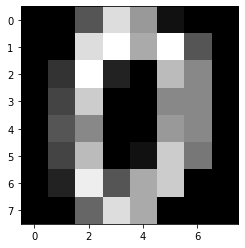

In [3]:
print(digits.images.shape)
print(digits.images[0])
plt.imshow(digits.images[0], cmap=plt.cm.gray);

In `data`, the same samples are represented as 1-d vectors of length 64.

In [4]:
print(digits.data.shape)
print(digits.data[0])

(1797, 64)
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


 In `target` you have the label corresponding to each image.

In [5]:
print(digits.target.shape)
print(digits.target)

(1797,)
[0 1 2 ... 8 9 8]


Let us visualize the 20 first entries of the dataset (image display kept small on purpose)

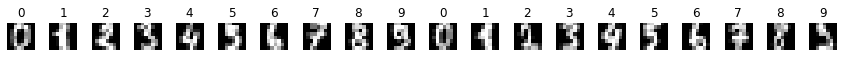

In [7]:
fig = plt.figure(figsize=(15, 0.5))
for index, (image, label) in enumerate(zip(digits.images[0:20], digits.target[0:20])):
    ax = fig.add_subplot(1, 20, index+1)
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title(label)
    ax.axis('off')

### Training/Test set

Before training our model, the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function will separate our dataset into a training set and a test set. The samples from the test set are never used during the training phase. This allows for a fair evaluation of the model's performance.

In [8]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_lbl, test_lbl = train_test_split(
    digits.data, digits.target, test_size=1/6)  # keep ~300 images as test set

We can check that all classes are well balanced in the training and test sets.

In [9]:
np.histogram(train_lbl, bins=10)

(array([149, 148, 150, 156, 148, 149, 153, 148, 145, 151]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

In [10]:
np.histogram(test_lbl, bins=10)

(array([29, 34, 27, 27, 33, 33, 28, 31, 29, 29]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

## Supervised learning: logistic regression

### Linear regression reminder

Linear regression is used to predict an dependent value $y$ from an n-dimensional vector $x$.
The assumption made here is that the output depends linearly on the input components, i.e. $y = mx + b$.

Given a set of input and output values, the goal is to compute $m$ and $b$ minimizing the [mean squared error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) between the predicted and actual outputs.
In scikit-learn this method is available through [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

### Logistic regression

Logistic regression is used to predict categorical data (e.g. yes/no, member/non-member, ham/spam, benign/malignant, ...).
It uses the output of a linear predictor, and maps it to a probability using a [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), such as the logistic function $s(z) = \frac{1}{1+e^{-z}}$. 
The output is a probability score between 0 and 1, and using a simple thresholding the class output will be positive if the probability is greater than 0.5, negative if not.
A [log-loss cost function](http://wiki.fast.ai/index.php/Logistic_Regression#Cost_Function) (not just the MSE as for linear regression) is used to train logistic regression (using gradient descent for instance).

[Multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) is an extension of the binary classification problem to a $n$-classes problem.

We can now create a logistic regression object and fit the parameters using the training data.

NB: as the dataset is quite simple, default parameters will give good results. Check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for fine-tuning possibilities.

In [11]:
from sklearn.linear_model import LogisticRegression

# All unspecified parameters are left to their default values.
logisticRegr = LogisticRegression(verbose=1, solver='liblinear', multi_class='auto')  # set solver and multi_class to silence warnings

In [12]:
logisticRegr.fit(train_img, train_lbl)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                   warm_start=False)

## Model performance evaluation

For a binary classification problem, let us denote by $TP$, $TN$, $FP$, and $FN$ the number of true positives, true negatives, false positives and false negatives.

### Accuracy

The *accuracy* is defined by $a = \frac{TP}{TP + TN + FP + FN}$

NB: in scikit-learn, models may have different definitions of the `score` method. For multi-class logistic regression, the value is the mean accuracy for each class.

In [13]:
score = logisticRegr.score(test_img, test_lbl)
print(f'accuracy = {score:.4f}')

accuracy = 0.9433


### F1 score

Accuracy only provides partial information about the performance of a model. Many other [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) are part of scikit-learn.

A metric that provides a more complete overview of the classification performance is the [F1 score](https://en.wikipedia.org/wiki/F1_score). It takes into account not only the valid predictions but also the incorrect ones, by combining precision and recall.

*Precision* is the number of positive predictions divided by the total number of positive class values predicted, i.e. $p=\frac{TP}{TP+FP}$. A low precision indicates a high number of false positives.

*Recall* is the number of positive predictions divided by the number of positive class values in the test data, i.e. $r=\frac{TP}{TP+FN}$. A low recall indicates a high number of false negatives.

Finally the F1 score is the harmonic mean between precision and recall, i.e. $F1=2\frac{p.r}{p+r}$

Let us compute the predicted labels in the test set:

In [19]:
pred_lbl = logisticRegr.predict(test_img)

In [20]:
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.multiclass import unique_labels

The [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) function computes the F1 score. The `average` parameter controls whether the result is computed globally over all classes (`average='micro'`) or if the F1 score is computed for each class then averaged (`average='macro'`).

In [21]:
f1_score(test_lbl, pred_lbl, average='micro')

0.9433333333333332

In [22]:
f1_score(test_lbl, pred_lbl, average='macro')

0.9437046060266848

`classification_report` provides a synthetic overview of all results for each class, as well as globally.

In [23]:
print(classification_report(test_lbl, pred_lbl))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.86      0.91      0.89        34
           2       1.00      0.96      0.98        27
           3       0.96      0.85      0.90        27
           4       1.00      0.94      0.97        33
           5       0.94      0.97      0.96        33
           6       1.00      1.00      1.00        28
           7       0.97      1.00      0.98        31
           8       0.86      0.83      0.84        29
           9       0.88      0.97      0.92        29

    accuracy                           0.94       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



### Confusion matrix

In the case of a multi-class problem, the *confusion matrix* is often used to present the results.

In [24]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[29  0  0  0  0  0  0  0  0  0]
 [ 0 31  0  0  0  0  0  0  2  1]
 [ 0  0 26  1  0  0  0  0  0  0]
 [ 0  0  0 23  0  2  0  1  0  1]
 [ 0  1  0  0 31  0  0  0  1  0]
 [ 0  0  0  0  0 32  0  0  0  1]
 [ 0  0  0  0  0  0 28  0  0  0]
 [ 0  0  0  0  0  0  0 31  0  0]
 [ 0  4  0  0  0  0  0  0 24  1]
 [ 0  0  0  0  0  0  0  0  1 28]]


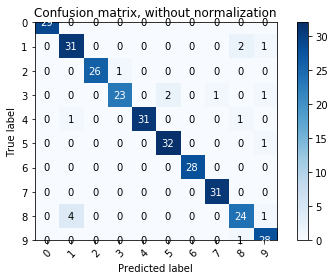

In [25]:
plot_confusion_matrix(test_lbl, pred_lbl, np.array(list(map(lambda x: str(x), range(10)))), normalize=False)

## Supervised learning: support-vector machines

[Support-vector machines (SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) are also used for classification tasks.
For a binary classification task of $n$-dimensional feature vectors, a linear SVM try to return the ($n-1$)-dimensional hyperplane that separate the two classes with the largest possible margin.
Nonlinear SVMs fit the maximum-margin hyperplane in a transformed feature space.
Although the classifier is a hyperplane in the transformed feature space, it may be nonlinear in the original input space. 

The goal here is to show that a method (e.g. the previously used logistic regression) can be substituted transparently for another one.

In [26]:
from sklearn import svm

Default parameters perform well on this dataset.
It might be needed to adjust $C$ and $\gamma$ (e.g. via a grid search) for optimal performance (cf. [SVC documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)).

In [27]:
clf = svm.SVC(gamma='scale')  # default kernel is RBF

In [28]:
clf.fit(train_img, train_lbl)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

The classification accuracy improves with respect to logistic regression (here `score` also computes mean accuracy, as in logistic regression).

In [29]:
clf.score(test_img, test_lbl)

0.9866666666666667

The F1 score is also improved.

In [30]:
pred_lbl_svm = clf.predict(test_img)
print(classification_report(test_lbl, pred_lbl_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.97      1.00      0.99        34
           2       1.00      1.00      1.00        27
           3       1.00      0.96      0.98        27
           4       1.00      0.94      0.97        33
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        31
           8       0.93      0.97      0.95        29
           9       1.00      1.00      1.00        29

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



## Unsupervised learning: $k$-means

[$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) aims at partitioning a samples into $k$ clusters, s.t. each sample belongs to the cluster having the closest mean. Its implementation is iterative, and relies on a prior knowledge of the number of clusters present. 

One important step in $k$-means clustering is the initialization, i.e. the choice of initial clusters to be refined.
This choice can have a significant impact on results.

In [31]:
from sklearn.cluster import KMeans

In [32]:
kmeans = KMeans(n_clusters=10)

In [33]:
kmeans.fit(digits.data)
km_labels = kmeans.predict(digits.data)

In [34]:
digits.target

array([0, 1, 2, ..., 8, 9, 8])

In [35]:
km_labels

array([4, 2, 2, ..., 2, 1, 1], dtype=int32)

Since we have ground truth information of classes, we can check if the $k$-means results make sense.
However as you can see, the labels produced by $k$-means and the ground truth ones do not match.
An agreement score based on [mutual information](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation), insensitive to labels permutation can be used to evaluate the results. 

In [36]:
from sklearn.metrics import adjusted_mutual_info_score

In [37]:
adjusted_mutual_info_score(digits.target, kmeans.labels_)

/Users/erickmaraz/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.7315242861613359

## Unsupervized learning: dimensionality reduction

You can also try to visualize the clusters as in this [scikit-learn demo](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html). Mapping the input features to lower dimensional embeddings (2D or 3D), e.g. using PCA otr tSNE is required for visualization. [This demo](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html) provides an overview of the possibilities.

In [38]:
from matplotlib import offsetbox

def plot_embedding(X, y, title=None):
    """Scale and visualize the embedding vectors."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [39]:
from sklearn import manifold

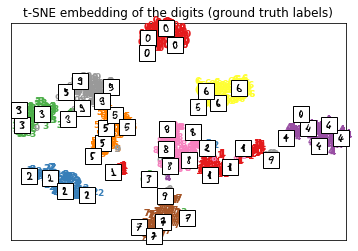

In [40]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(digits.data)

plot_embedding(X_tsne, digits.target,
               "t-SNE embedding of the digits (ground truth labels)")

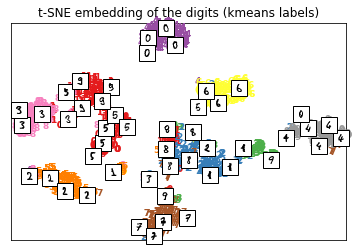

In [41]:
plot_embedding(X_tsne, km_labels,
               "t-SNE embedding of the digits (kmeans labels)")